In [1]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import utils
import atari_wrappers
import matplotlib.pyplot as plt


from framebuffer import FrameBuffer
from experience_replay import PrioritizedExperienceReplay

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
seed = 228
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
ENV_NAME = "BreakoutNoFrameskip-v4"

env = atari_wrappers.make_env(env_name=ENV_NAME, h=84, w=84, seed=seed)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

In [5]:
from models import DuelingDQNAgent
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DuelingDQNAgent(agent.state_shape, agent.n_actions, epsilon=0).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [6]:
from experience_replay import make_PER

exp_replay = make_PER(env, agent, init_size=10**5, size=10**5)

buffer size = 100000, epsilon = 0.73450


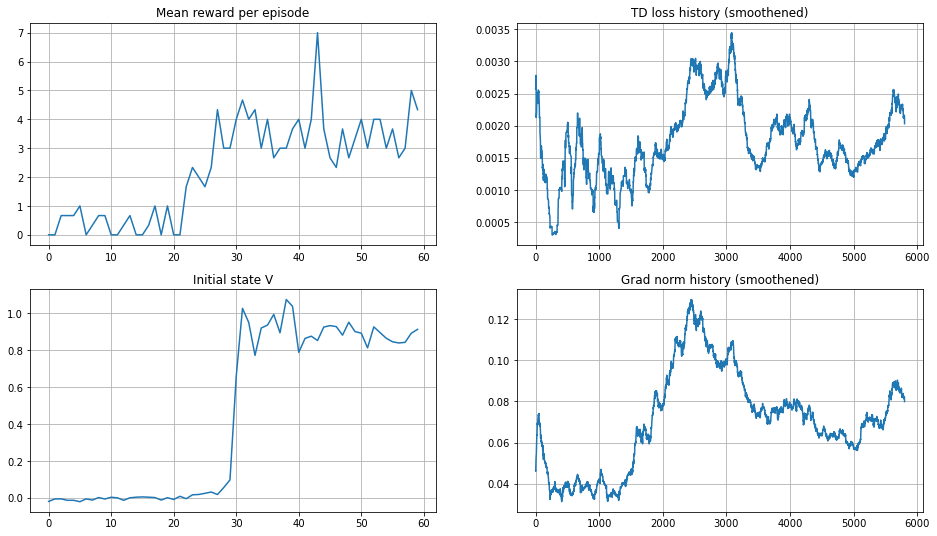

Mean reward: 4.3:  10%|▉         | 299994/3000001 [1:04:39<9:23:01, 79.93it/s]  

Stopping plotting to reduce training time.


Mean reward: 10.7: 100%|██████████| 3000001/3000001 [10:37:28<00:00, 78.43it/s]   


In [7]:
from losses import compute_td_loss_double_q_PER
from train import train_PER

history = train_PER(env, agent, target_network, exp_replay, compute_td_loss_double_q_PER, device, batch_size=32, total_steps=3 * 10**6, h=84, w=84)

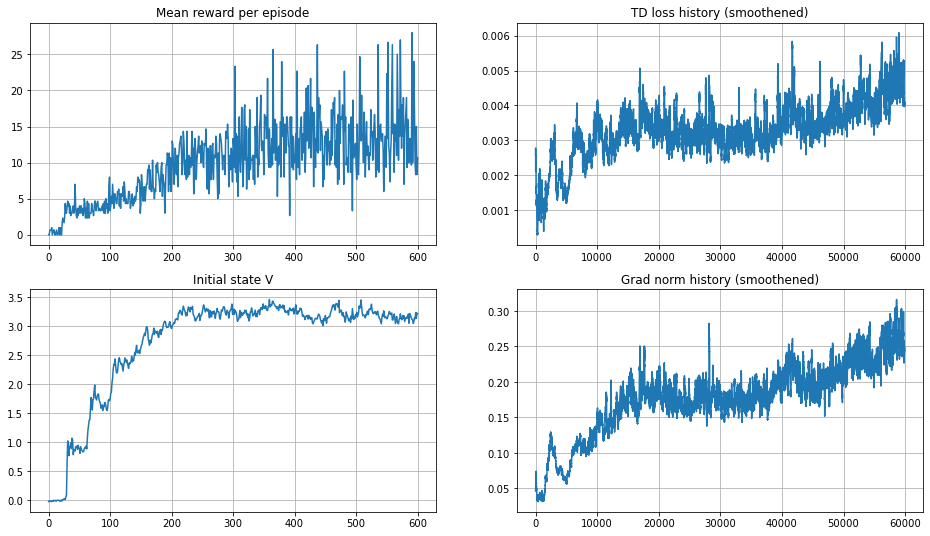

In [8]:
plt.figure(figsize=[16, 9])
plt.subplot(2, 2, 1)
plt.title("Mean reward per episode")
plt.plot(history['reward_history'])
plt.grid()

assert not np.isnan(history['td_loss_history'][-1])
plt.subplot(2, 2, 2)
plt.title("TD loss history (smoothened)")
plt.plot(utils.smoothen(history['td_loss_history']))
plt.grid()

plt.subplot(2, 2, 3)
plt.title("Initial state V")
plt.plot(history['initial_state_v_history'])
plt.grid()

plt.subplot(2, 2, 4)
plt.title("Grad norm history (smoothened)")
plt.plot(utils.smoothen(history['grad_norm_history']))
plt.grid()

plt.show()

In [9]:
torch.save(agent.state_dict(), "./models/per_dueling_dqn_bs_32_84x84.pth")

Final scoring is done on a whole episode with all 5 lives.

In [10]:
n_lives = 5

final_score = utils.evaluate(
              atari_wrappers.make_env(clip_rewards=False, h=84, w=84, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 10, 'not as cool as DQN can'
print('Cool!')

final score: 56.0
Cool!


# Record a video

In [11]:
#agent.load_state_dict(torch.load("./models/per_dueling_dqn_bs_32_84x84.pth"))

In [12]:
# record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(atari_wrappers.make_env(h=84, w=84), directory="videos/per_dueling_dqn/", force=True)
sessions = [utils.evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]
env_monitor.close()